In [86]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
import tensorflow as tf
from collections import OrderedDict
import tqdm
import matplotlib.pyplot as plt
from plotting import plot_3d, plot_2d
from tf2kfac import tf2KFAC
import tensorflow_probability as tfp
%matplotlib widget

### First lets compare the pure loss computation

In [87]:
input_data = tf.convert_to_tensor(np.load('data/input.npy'), dtype=tf.float32)
weights = tf.convert_to_tensor(np.load('data/weights.npy'), dtype=tf.float32)
target = tf.convert_to_tensor(np.load('data/target.npy'), dtype=tf.float32)

In [88]:
# need a softmax layer to define the output distribution p(y | x) to compute the fisher
print(input_data.shape)
with tf.GradientTape() as g:
    g.watch(weights)
    prediction = input_data@weights
    loss = tf.reduce_mean(((prediction) - target)**2)  
print('Loss', loss)
print('Gradients', g.gradient(loss, weights))
print(prediction.shape)

(16, 2)
Loss tf.Tensor(5.943384, shape=(), dtype=float32)
Gradients tf.Tensor(
[[ 0.47266078]
 [-5.364277  ]], shape=(2, 1), dtype=float32)
(16, 1)


### KFAC

In [97]:
input_data = tf.convert_to_tensor(np.load('data/input.npy'), dtype=tf.float32)
weights = tf.convert_to_tensor(np.load('data/weights.npy'), dtype=tf.float32)
target = tf.convert_to_tensor(np.load('data/target.npy'), dtype=tf.float32)
kfac = tf2KFAC(tinv=10,
               lr0=0.005,
               cov_weight=1.,
               cov_moving_weight=1.,
               damping=0.001,
               conv_approx='mg',
               damping_method='factored_tikhonov',
               ft_method='original')

dist = tfp.distributions.Normal(0.0, tfsqrt(0.5))

history = []
for i in range(1):
    activations = input_data
    with tf.GradientTape(persistent=True) as g:
        g.watch(weights)
        prediction = input_data@weights
        model_dist = tf.reduce_mean((prediction - target)**2)
        log_prob = - dist.log_prob(prediction)
        loss = 
    sensitivities = g.gradient(log_prob, prediction)
    
    grads = g.gradient(loss, weights)
    
    history.append(np.concatenate([weights.numpy().reshape(-1), loss.numpy()[None]]))
    ng = kfac.compute_updates([activations], [sensitivities], [grads], i)
    weights = weights + ng[0]

    if i % 2 == 0:
        print(i, 'Loss', loss)
history = np.array(history, dtype=np.float32)


Factored Tikhonov damping
0 Loss tf.Tensor(5.943384, shape=(), dtype=float32)


In [98]:
print(kfac.m_aa[0])
print(kfac.m_ss[0])

tf.Tensor(
[[ 0.49239448 -0.20377488]
 [-0.20377488  1.3904603 ]], shape=(2, 2), dtype=float32)
tf.Tensor([[88.6011]], shape=(1, 1), dtype=float32)


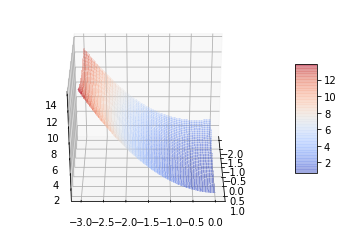

In [67]:
plt.close()
plot_3d(history, input_data, target)
plt.show()

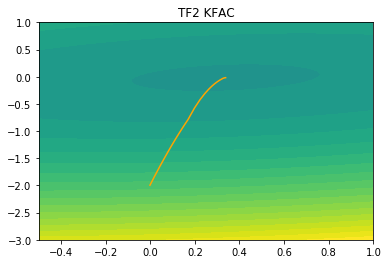

In [17]:
plt.close()
plt.title('TF2 KFAC')
plot_2d(history, input_data, target, (-0.5, 1, -3, 1))
plt.show()